In [4]:
# Импортируе нужные библиоткеи.

import pandas as pd
import numpy as np

from scipy import stats
import statsmodels.api as sm
from tqdm.auto import tqdm

import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('ggplot')
%matplotlib inline

In [13]:
# Создаем функцию, которая делает А/А тесты, используя т-критерий:

# s1 - sample1
# s2 - sample 2
# simulations - number of tests
# n_s - sub-sample size
# a - alpha or p-value
# FPR - False Postitive Rate.

def aa_test(sample1, sample2, simulations = 1000, n_s=1000, a=0.05):

    res = []
    for i in tqdm(range(simulations)):
        s1 = sample1.sample(n_s, replace = False).values
        s2 = sample2.sample(n_s, replace = False).values
        res.append(stats.ttest_ind(s1, s2, equal_var = False)[1]) # сохраняем pvalue

    plt.hist(res, bins = 50)
    plt.style.use('ggplot')
    plt.xlabel('pvalues')
    plt.ylabel('frequency')
    plt.title("Histogram of ttest A/A simulations ")
    plt.show()
    
    return {'Number od simulations': simulations,
            'Sub sample size': n_s,
            'Alpha': a, 
            'FPR': sum(np.array(res) < a) / simulations}

### Задача:

Запустите A/A-тест
Посчитайте FPR на уровне альфа = 0.05 (ставьте подвыборки без возвращения объемом 1000). Вы увидите, что FPR > альфа! Нам нужно наоборот – чтобы было меньше.

Найдите причины поломки сплит-системы, ориентируясь на результаты эксперимента (подсказка: найдите аномалию в версии приложения)

Напишите выводы, которые можно сделать на основе анализа результатов A/A-теста
 
### Как найти причины поломки?

Вам доступна версия мобильного приложения (МП) каждого пользователя. Эту полезную информацию можно использовать для исследования проблемы:

1. Посчитайте конверсию (коэффициент покупок), группируя по варианту и версии МП. Возможно уже станет ясно где именно причины поломки.
2. Посчитайте pvalue для каждой версии МП.
3. Найдите версии, где pvalue < 0.05
4. Исключите версию с pvalue < 0.05 из основного датафрейма
5. Повторно запустите расчет FPR через A/A. Теперь FPR < альфа
6. Вы нашли поломку

### Описание колонок:

1. experimentVariant – вариант эксперимента
2. version – версия приложения
3. purchase – факт покупки

In [6]:
# Считываем датафрейм, одновременно убирая колонку, которая дублирует индексы.

df = pd.read_csv('https://stepik.org/media/attachments/lesson/396012/hw_aa.csv', sep=';', 
                 usecols=['experimentVariant', 
                          'version', 
                          'purchase'])

In [7]:
df.head()

,experimentVariant,version,purchase
0,1,v2.8.0,0
1,0,v2.9.0,0
2,1,v2.9.0,0
3,1,v2.8.0,0
4,1,v2.8.0,0


In [10]:
# Для удобства переименовывем колонку, чтобы все символы были в нижнем регистре.

df.rename(columns={'experimentVariant':'experiment_variant'}, inplace=True)

In [28]:
df.head()

,experiment_variant,version,purchase
0,1,v2.8.0,0
1,0,v2.9.0,0
2,1,v2.9.0,0
3,1,v2.8.0,0
4,1,v2.8.0,0


In [29]:
# Типы переменных адекватные.

df.dtypes

experiment_variant     int64
version               object
purchase               int64
dtype: object

In [30]:
df.shape

(127018, 3)

In [11]:
# Исследуем наши группы на предмет конверсии и количества пользователей.
# Видим, что сплитовалка между вариантами групп работает корректно, оджнако конверсия сильно отличается.
# Ниже выясняем более точно, в чем причина.

df.groupby(['experiment_variant']) \
    .agg({'purchase': 'mean', 'version':'count'})

,purchase,version
experiment_variant,,
0,0.023945,63102
1,0.053242,63916


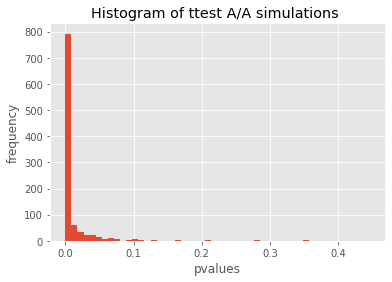

{'Number od simulations': 1000,
 'Sub sample size': 1000,
 'Alpha': 0.05,
 'FPR': 0.938}

In [14]:
# Запускаем А/А тест и видим, что действительно FPR у нас очень высокий, а значит, что количество значений p-value
# в нашем тесте очень часто опускается ниже 0.05.

sample1 = df[df.experiment_variant == 1].purchase
sample2 = df[df.experiment_variant == 0].purchase
aa_test(sample1, sample2)

In [15]:
# Т.к. у нас есть данные только по версии приложения, варианту группы и факту покупки, анализируем именно эти
# показатели. Видим по количеству пользователей, что сплитовалка по всем вариантам группы и версии приложения
# работает корректно в рамках количества людей.

# Однако также мы видим, что конверсия немного отличается в каждой из версий приложения, но разительное отличие
# набюлюдается в v2.8.0 (а именно - почти в 46 раз!).

df.groupby(['experiment_variant', 'version']) \
    .agg({'purchase': 'mean', 'version':'count'}) \
    .rename(columns={'purchase':'conversion', 'version':'num_of_users'})

conversion  num_of_users
experiment_variant version                           
0                  v2.8.0      0.000993         41283
                   v2.9.0      0.074658         11921
                   v3.7.4.0    0.059943          4204
                   v3.8.0.0    0.057604          5694
1                  v2.8.0      0.045606         41552
                   v2.9.0      0.071304         12033
                   v3.7.4.0    0.063018          4221
                   v3.8.0.0    0.062848          6110

In [16]:
# Подсчет конверсии. Видим, что конверсия упала при перехроде с v2.9.0 на v3.7.4.0 и далее еще раз упала при 
# переходе на v3.8.0.0. Пичем это случилось в обоих вариантах эксперимента.

df.groupby(['experiment_variant', 'version']) \
    .agg({'purchase': 'mean'}).mul(100).round(2) \
    .rename(columns={'purchase': 'conversion_rate'})

conversion_rate
experiment_variant version                  
0                  v2.8.0               0.10
                   v2.9.0               7.47
                   v3.7.4.0             5.99
                   v3.8.0.0             5.76
1                  v2.8.0               4.56
                   v2.9.0               7.13
                   v3.7.4.0             6.30
                   v3.8.0.0             6.28

In [22]:
# Делаем последовательно А/А тесты по всем группам, в результате которых мы также видим невероятно высокий 
# FPR по v2.8.0. По другим версиям есть значения тоже на грани, но они не сильно выбиваются из общей картины.

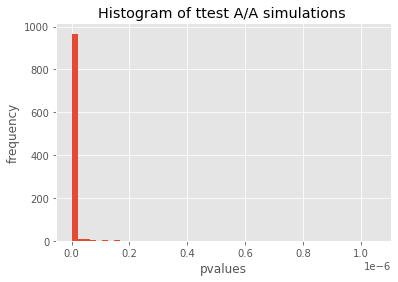

{'Number od simulations': 1000,
 'Sub sample size': 1000,
 'Alpha': 0.05,
 'FPR': 1.0}

In [18]:
s1 = df[df.experiment_variant == 0].query('version == "v2.8.0"').purchase
s2 = df[df.experiment_variant == 1].query('version == "v2.8.0"').purchase
aa_test(s1, s2)

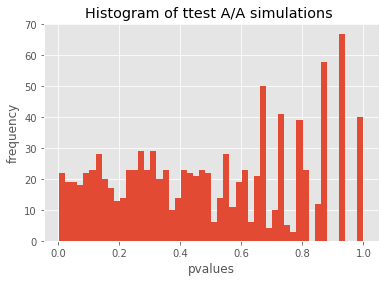

{'Number od simulations': 1000,
 'Sub sample size': 1000,
 'Alpha': 0.05,
 'FPR': 0.047}

In [19]:
s1 = df[df.experiment_variant == 0].query('version == "v2.9.0"').purchase
s2 = df[df.experiment_variant == 1].query('version == "v2.9.0"').purchase
aa_test(s1, s2)

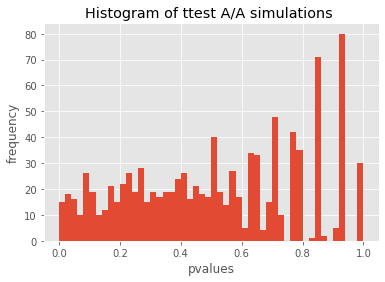

{'Number od simulations': 1000,
 'Sub sample size': 1000,
 'Alpha': 0.05,
 'FPR': 0.045}

In [20]:
s1 = df[df.experiment_variant == 0].query('version == "v3.7.4.0"').purchase
s2 = df[df.experiment_variant == 1].query('version == "v3.7.4.0"').purchase
aa_test(s1, s2)

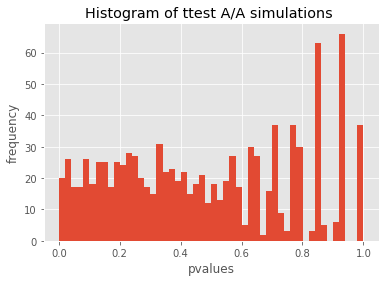

{'Number od simulations': 1000,
 'Sub sample size': 1000,
 'Alpha': 0.05,
 'FPR': 0.054}

In [21]:
s1 = df[df.experiment_variant == 0].query('version == "v3.8.0.0"').purchase
s2 = df[df.experiment_variant == 1].query('version == "v3.8.0.0"').purchase
aa_test(s1, s2)

In [23]:
# Делаем А/А тест, исключая версию v2.8.0. И видим, что по сравнению с первым тестом, который мы делали, в этом
# FPR ниже Alpha, который мы обозначили в рамках эксперимента.

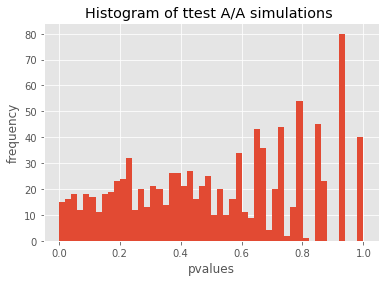

{'Number od simulations': 1000,
 'Sub sample size': 1000,
 'Alpha': 0.05,
 'FPR': 0.038}

In [24]:
s1 = df[(df.experiment_variant == 0) & (df.version != 'v2.8.0')].purchase
s2 = df[(df.experiment_variant == 1) & (df.version != 'v2.8.0')].purchase
aa_test(s1, s2)

### Ответ:

Основная поломка в данном задании заключается в версии приложения. В рамках самой старой версии v2.8.0 что-то сломалось, из за чего в разные группы А/А теста у нас попадают покупатели с невероятно сильно отличающейся конверсией.

Для более детального анализа причины нам не достает данных, но пока мы не разберемся и не починим систему так, чтобы в две группы, в рамках А/А теста, у нас попадали люди с одинаковой конверсией, эту группу стоит исключить из дальнейших А/Б тестов, чтобы они не смещали общую картину.

# ответ преподавателя: вы верно решили задание!

Логика решения задачи была верной: вы последовательно сравнивали градации в измерениях по целевой переменной. 


В качестве бонуса, ниже показано альтернативное решение задачи

In [6]:

from statsmodels.stats.proportion import proportions_ztest
df = pd.read_csv('hw_aa.csv', sep=';',index_col=0, decimal=',')
df.head()

,uid,experimentVariant,version,purchase
1,c4ca4238a0b923820dcc509a6f75849b,1,v2.8.0,0
2,c81e728d9d4c2f636f067f89cc14862c,0,v2.9.0,0
3,eccbc87e4b5ce2fe28308fd9f2a7baf3,1,v2.9.0,0
4,a87ff679a2f3e71d9181a67b7542122c,1,v2.8.0,0
5,e4da3b7fbbce2345d7772b0674a318d5,1,v2.8.0,0


In [9]:

# основная функция для расчета АА с синтетическими тестами
def metric_fpr(df_x, df_y, metric_col, n_sim, n_s_perc, n_s_min, estimator, *args, **kwargs):
    stat_res = {
        'aa' : {
            'pvalue': [], 
            'mu_x': [], 
            'mu_y': []
        },
        'fpr': {
            'fpr_95': 0
        }
    }
    
    for sim in range(n_sim):
        
        # по-умолчанию берем %(n_s_perc) наблюдений от исходной, но не более n_s_min
        x = df_x[metric_col].sample(int(min(n_s_min, len(df_x) * n_s_perc)), replace = False).values 
        y = df_y[metric_col].sample(int(min(n_s_min, len(df_y) * n_s_perc)), replace = False).values

        if estimator == 'prop':
            counts = np.array([sum(x),sum(y)])
            nobs = np.array([len(x),len(y)])
            stat, pvalue = proportions_ztest(counts, nobs, *args, **kwargs)
        
        if estimator == 'ttest':
            stat, pvalue = stats.ttest_ind(x, y, *args, **kwargs)
            
        stat_res['aa']['pvalue'].append(pvalue)
        stat_res['aa']['mu_x'].append(np.mean(x))
        stat_res['aa']['mu_y'].append(np.mean(y))
        
    
    stat_res['fpr']['fpr_95'] =  float(sum(np.array(stat_res['aa']['pvalue']) <= 0.05) / n_sim)
    
    return stat_res

# считаем АА по градациям внутри измерений (группировок)
def fpr_report(df, metric_col, variant_col, group_col, n_sim, n_s_perc, n_s_min, estimator, *args, **kwargs):
    list_fpr = []
    list_group = list(pd.unique(df[group_col]))
    
    for v in range(len(list_group)):
        df_x = df[(df[variant_col] == 0) & (df[group_col] == list_group[v])]
        df_y = df[(df[variant_col] == 1) & (df[group_col] == list_group[v])]
        
        if (len(df_x) == 0) | (len(df_y) == 0):
            continue
        else:
            cr_x = sum(df_x[metric]) / len(df_x)
            cr_y = sum(df_y[metric]) / len(df_y)

            fpr = {}
            fpr = metric_fpr(
                df_x = df_x, 
                df_y = df_y, 
                metric_col = metric, 
                n_sim = n_sim,
                n_s_perc = n_s_perc,
                n_s_min = n_s_min,
                estimator = estimator, *args, **kwargs
            )
            is_fpr = (fpr['fpr']['fpr_95']<=0.05)
            list_fpr.append([list_group[v],cr_x,cr_y,fpr['fpr']['fpr_95'],is_fpr])

    report = pd.DataFrame.from_records(list_fpr, columns=['group','cr_x','cr_y','fpr_95','is_fpr'])
    
    return report

# параметры
n_sim = 500 # количество симуляций
n_s_perc = 0.9 # % наблюдений в подвыборках
n_s_min = 1000 # но не более константы
metric = 'purchase'
variant = 'experimentVariant'
group = 'version'

res = fpr_report(
    df = df,
    metric_col = metric,
    variant_col = variant,
    group_col = group,
    n_sim = n_sim,
    n_s_perc = n_s_perc,
    n_s_min = n_s_min,
    estimator = 'prop'
)

res

/Users/iskander/opt/anaconda3/lib/python3.7/site-packages/statsmodels/stats/weightstats.py:671: RuntimeWarning: invalid value encountered in double_scalars
  zstat = value / std_diff
/Users/iskander/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in less_equal


,group,cr_x,cr_y,fpr_95,is_fpr
0,3.8.2.0,0.066557,0.067081,0.044,True
1,2.8.0,0.000000,0.045606,1.000,False
2,2.9.0,0.074658,0.071304,0.044,True
3,3.7.4.0,0.059943,0.063018,0.038,True
4,3.8.0.0,0.057604,0.062848,0.046,True
5,3.8.3.0,0.060475,0.052519,0.000,True
6,3.8.1.0,0.000000,0.000000,0.000,True
7,3.7.2.0,0.000000,0.000000,0.000,True


Видим, что проблемы в 2.8.0 версии. По сути мы могли бы итерироваться по другим измерениям и в конце концов нашли бы причину на самом низком уровне

In [8]:
np.random.seed(1)
group = 'operatingSystem'
df_fltrd = df[(df['version']!='2.8.0')]

res = fpr_report(
    df = df_fltrd,
    metric_col = metric,
    variant_col = variant,
    group_col = group,
    n_sim = n_sim,
    n_s_perc = n_s_perc,
    n_s_min = n_s_min,
    estimator = 'prop'
)

res


,group,cr_x,cr_y,fpr_95,is_fpr
0,ANDROID,0.065903,0.066633,0.038,True
1,IOS,0.074658,0.071292,0.044,True
